In [29]:
import os
from PIL import Image, ImageOps
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
dataset_path = "Dataset"
os.listdir(dataset_path)
image_paths = []
labels = []
for filename in os.listdir(dataset_path):
    if filename.endswith((".jpg", ".JPG", ".png", ".jpeg")):
        image_paths.append(os.path.join(dataset_path, filename))
        file_name = filename.split(".")[0]
        label = file_name[7:]
        labels.append(label)

In [31]:
IMAGE_SIZE = 300
VECTOR_DIM = 300 * 300 * 3

# Khởi tạo FAISS index
index = faiss.IndexFlatL2(VECTOR_DIM)
label_map = []

In [32]:
# Chuyển đổi hình ảnh thành vector
def image_to_vector(image_path):
    img = Image.open(image_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img)

    # Handle grayscale images (convert to RGB)
    if len(img_array.shape) == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)

    # Normalize pixel values to [0, 1]
    vector = img_array.astype('float32') / 255.0
    return vector.flatten()

In [33]:
data = {'image_path': image_paths, 'label': labels}
df = pd.DataFrame(data)
print(df)

                               image_path               label
0         Dataset/Avatar_Andrew_Cuomo.jpg        Andrew_Cuomo
1           Dataset/Avatar_Phuc_Thinh.JPG          Phuc_Thinh
2             Dataset/Avatar_Tien_Huy.jpg            Tien_Huy
3           Dataset/Avatar_Amy_Pascal.jpg          Amy_Pascal
4       Dataset/Avatar_Andrew_Bernard.jpg      Andrew_Bernard
5          Dataset/Avatar_Amy_Redford.jpg         Amy_Redford
6        Dataset/Avatar_Aaron_Eckhart.jpg       Aaron_Eckhart
7         Dataset/Avatar_Hoang_Nguyen.jpg        Hoang_Nguyen
8             Dataset/Avatar_Dang_Nha.jpg            Dang_Nha
9             Dataset/Avatar_Anh_Khoi.JPG            Anh_Khoi
10           Dataset/Avatar_Quoc_Thai.JPG           Quoc_Thai
11         Dataset/Avatar_Thang_Duong.jpg         Thang_Duong
12           Dataset/Avatar_Minh_Chau.jpg           Minh_Chau
13        Dataset/Avatar_Anil_Ramsook.jpg        Anil_Ramsook
14         Dataset/Avatar_Thuan_Duong.jpg         Thuan_Duong
15      

In [34]:
for idx, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    try:
        vector = image_to_vector(image_path)
        index.add(np.array([vector]))
        label_map.append(label)
    except Exception as e:
        print(f'Error processing {image_path}: {e}')

faiss.write_index(index, "employee_images.index")
np.save("label_map.npy", np.array(label_map))

print(label_map)

['Andrew_Cuomo', 'Phuc_Thinh', 'Tien_Huy', 'Amy_Pascal', 'Andrew_Bernard', 'Amy_Redford', 'Aaron_Eckhart', 'Hoang_Nguyen', 'Dang_Nha', 'Anh_Khoi', 'Quoc_Thai', 'Thang_Duong', 'Minh_Chau', 'Anil_Ramsook', 'Thuan_Duong', 'Aaron_Guiel', 'Carla_Gay_Balingit', 'Camille_Lewis']


In [35]:
# Xây dựng hàm tìm kiếm và hiển thị kết quả
def search_similar_images(query_image_path, k=5):
    # Load image and labels
    index = faiss.read_index("employee_images.index")
    label_map = np.load("label_map.npy")

    # Convert query image to vector
    query_vector = image_to_vector(query_image_path)

    # Search in Faiss
    distances, indices = index.search(np.array([query_vector]), k)

    results = []
    for i in range(len(indices[0])):
        employee_name = label_map[indices[0][i]]
        distance = distances[0][i]
        results.append((employee_name, distance))

    return results

In [40]:
# Hiển thị top 5 ảnh tương đồng
def display_query_and_top_matches(query_image_path):
    query_img = Image.open(query_image_path)
    query_img = query_img.resize((300, 300))

    plt.figure(figsize=(5,5))
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()

    matches = search_similar_images(query_image_path)

    top_matches = []
    for name, distance in matches:
        img_path = df[df['label'] == name]['image_path'].values[0]
        top_matches.append((name, distance, img_path))
    

    plt.figure(figsize=(15,5))
    for i, (name, distance, img_path) in enumerate(top_matches):
        img = Image.open(img_path)
        img = img.resize((300, 300))

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{name}\nDist: {distance:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

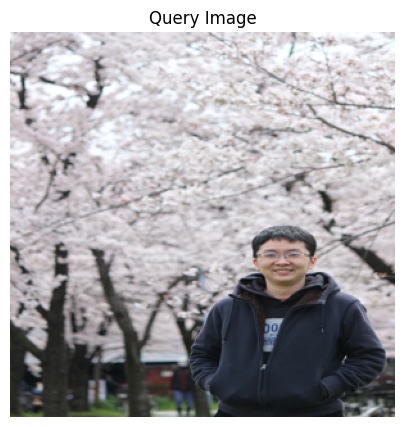

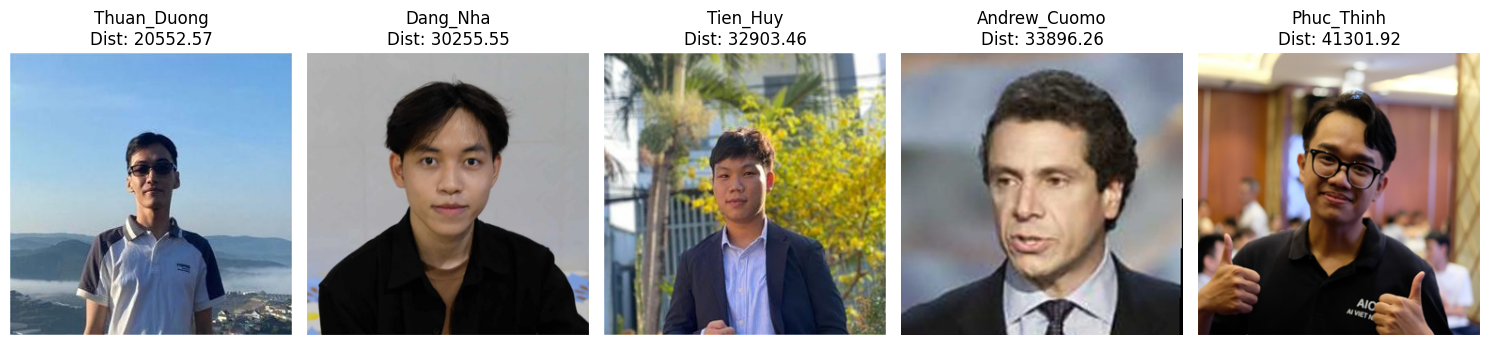

In [41]:
query_image_sample='/Users/vytran/Downloads/IMG_8055.jpeg'
display_query_and_top_matches(query_image_sample)